# Recreating NeRF
This is a PyTorch implementation based on the paper: https://arxiv.org/abs/2003.08934. The code takes mostly after the officially tiny nerf implementation: https://colab.research.google.com/github/bmild/nerf/blob/master/tiny_nerf.ipynb

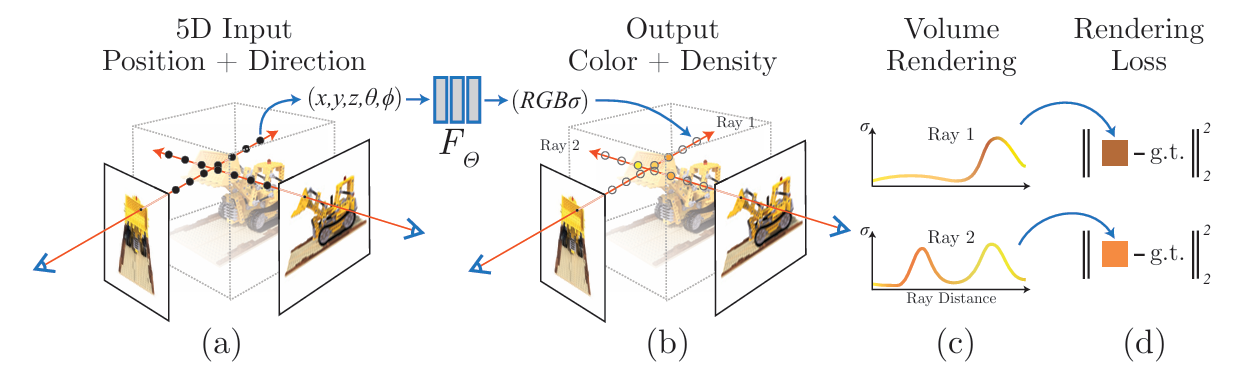

## Imports + Data


In [3]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.init as init
import time
import numpy as np
import torch.nn.functional as F
import os
from tqdm import tqdm
from ipywidgets import interactive, widgets

if not os.path.exists('tiny_nerf_data.npz'):
    !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

--2025-03-01 15:44:18--  http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Resolving cseweb.ucsd.edu (cseweb.ucsd.edu)... 132.239.8.30
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz [following]
--2025-03-01 15:44:19--  https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12727482 (12M)
Saving to: ‘tiny_nerf_data.npz’

tiny_nerf_data.npz  100%[===================>]  12.14M  4.97MB/s    in 2.4s    

2025-03-01 15:44:22 (4.97 MB/s) - ‘tiny_nerf_data.npz’ saved [12727482/12727482]



## Encoding + Model

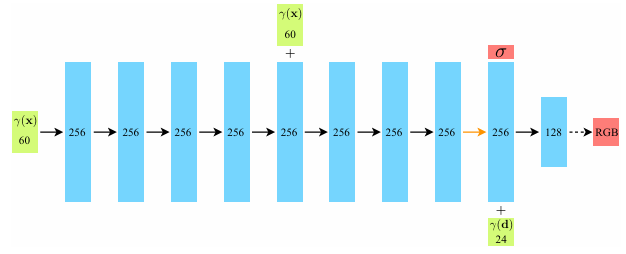

$$\gamma(p) = (\sin(2^0\pi p), \cos(2^0\pi p), \dots, \sin(2^{L-1}\pi p), \cos(2^{L-1}\pi p))$$

In [4]:
def encoding(x, L= 10):
    res = []
    for l in range(L):
        for fn in [torch.sin, torch.cos]:
            res.append(fn((2 ** l) * torch.pi * x))
    return torch.cat(res, dim=-1)

In [5]:
x = torch.Tensor([3.1,5.6,7.3])
y = encoding(x, L=10)
y.shape

torch.Size([60])

In [6]:
class NeRF(nn.Module):
    def __init__(self, pos_enc_dim=60, view_enc_dim=24, hidden=256) -> None:
        super().__init__()

        self.linear1 = nn.Sequential(nn.Linear(pos_enc_dim, hidden), nn.ReLU())

        self.pre_skip_linear = nn.Sequential()
        for _ in range(6):
            self.pre_skip_linear.append(nn.Linear(hidden, hidden))
            self.pre_skip_linear.append(nn.ReLU())

        self.linear_skip = nn.Sequential(nn.Linear(pos_enc_dim + hidden, hidden), nn.ReLU())

        self.post_skip_linear = nn.Sequential()
        for _ in range(2):
            self.post_skip_linear.append(nn.Linear(hidden, hidden))
            self.post_skip_linear.append(nn.ReLU())

        self.density_layer = nn.Sequential(nn.Linear(hidden, 1), nn.ReLU())

        self.linear2 = nn.Linear(hidden, hidden)

        self.color_linear1 = nn.Sequential(nn.Linear(hidden + view_enc_dim, hidden // 2), nn.ReLU())

        self.color_linear2 = nn.Sequential(nn.Linear(hidden // 2, 3), nn.Sigmoid())


    def forward(self, input):
        positions = input[..., :3]
        view_dirs = input[..., 3:]

        # Encode
        pos_enc = encoding(positions, L=10)
        view_enc = encoding(view_dirs, L=4)

        x = self.linear1(pos_enc)
        x = self.pre_skip_linear(x)

        #Skip connection
        x = torch.cat([x, pos_enc], dim=-1)
        x = self.linear_skip(x)

        x = self.post_skip_linear(x)

        # Density
        sigma = self.density_layer(x)

        x = self.linear2(x)

        # View encoding
        x = torch.cat([x, view_enc], dim=-1)
        x = self.color_linear1(x)

        # Color prediction
        rgb = self.color_linear2(x)

        return torch.cat([sigma, rgb], dim=-1)



## Get Ray + Render

In [7]:
def get_rays(H, W, focal, c2w):
  """
  Generate rays for a given camera configuration.

  Args:
    H: Image height.
    W: Image width.
    focal: Focal length.
    c2w: Camera-to-world transformation matrix (4x4).

  Returns:
    rays_o: Ray origins (H*W, 3).
    rays_d: Ray directions (H*W, 3).
  """
  device = c2w.device  # Get the device of c2w
  focal = torch.from_numpy(focal).to(device)
  # print(type(H), type(W), type(focal), type(c2w))

  i, j = torch.meshgrid(
      torch.arange(W, dtype=torch.float32, device=device),
      torch.arange(H, dtype=torch.float32, device=device),
      indexing='xy'
  )
  dirs = torch.stack(
      [(i - W * .5) / focal, -(j - H * .5) / focal, -torch.ones_like(i, device = device)], -1
  )

  rays_d = torch.sum(dirs[..., None, :] * c2w[:3, :3], -1)
  rays_d = rays_d.view(-1, 3)
  rays_o = c2w[:3, -1].expand(rays_d.shape)

  return rays_o, rays_d

def render_rays(network_fn, rays_o, rays_d, near, far, N_samples, device, rand=False, embed_fn=None, chunk=1024*4):
    def batchify(fn, chunk):
        return lambda inputs: torch.cat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)

    # Sampling
    z_vals = torch.linspace(near, far, steps=N_samples, device=device)

    if rand:
        z_vals += torch.rand(*z_vals.shape[:-1], N_samples, device=rays_o.device) * (far - near) / N_samples

    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]

    # Normalize view directions
    view_dirs = rays_d / torch.norm(rays_d, dim=-1, keepdim=True)
    view_dirs = view_dirs[..., None, :].expand(pts.shape)

    input_pts = torch.cat((pts, view_dirs), dim=-1)
    raw = batchify(network_fn, chunk)(input_pts)

    # Apply activations here instead of in network
    sigma_a = raw[...,0]  # Shape: [batch, N_samples]
    rgb = raw[...,1:]    # Shape: [batch, N_samples, 3]

    # Improved volume rendering
    dists = z_vals[..., 1:] - z_vals[..., :-1]  # Shape: [batch, N_samples-1]
    dists = torch.cat([dists, torch.tensor([1e10], device=device)], -1)

    # No need to manually expand dists as broadcasting will handle it
    alpha = 1. - torch.exp(-sigma_a * dists)  # Shape: [batch, N_samples]
    alpha = alpha.unsqueeze(-1)  # Shape: [batch, N_samples, 1]

    # Computing transmittance
    ones_shape = (alpha.shape[0], 1, 1)
    T = torch.cumprod(
        torch.cat([
            torch.ones(ones_shape, device=device),
            1. - alpha + 1e-10
        ], dim=1),
        dim=1
    )[:, :-1]  # Shape: [batch, N_samples, 1]

    weights = alpha * T  # Shape: [batch, N_samples, 1]

    # Compute final colors and depths
    rgb_map = torch.sum(weights * rgb, dim=1)  # Sum along sample dimension
    depth_map = torch.sum(weights.squeeze(-1) * z_vals, dim=-1)  # Shape: [batch]
    acc_map = torch.sum(weights.squeeze(-1), dim=-1)  # Shape: [batch]

    return rgb_map, depth_map, acc_map

## Train Loop

In [8]:
def train(images, poses, H, W, focal, testpose, testimg, device):
    """
    Trains the NeRF model.

    Args:
        images: A NumPy array of training images.
        poses: A NumPy array of camera poses corresponding to the training images.
        H: The height of the images.
        W: The width of the images.
        focal: The focal length of the camera.
        testpose: A NumPy array representing the camera pose for the test image.
        testimg: A NumPy array representing the test image.
        device: The device to use for training (e.g., 'cuda' or 'cpu').

    """
    # Print the device being used
    print(f"Using device: {device}")

    # Instantiate the NeRF model and move it to the specified device
    model = NeRF().to(device)

    # Define the loss function (Mean Squared Error)
    criterion = nn.MSELoss(reduction='mean')

    # Define the optimizer (Adam)
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

    # Define the learning rate scheduler (ExponentialLR)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

    # Set training parameters
    n_iter = 10000  # Number of training iterations
    n_samples = 64 # Number of samples along each ray
    i_plot = 50    # Frequency of plotting results
    psnrs = []    # List to store PSNR values
    iternums = []  # List to store iteration numbers
    t = time.time()  # Start time

    # Convert data to tensors and move to device for efficiency
    images_tensor = torch.from_numpy(images).float().to(device)
    poses_tensor = torch.from_numpy(poses).float().to(device)

    # Training loop
    for i in range(n_iter):
        # Randomly select an image and corresponding pose
        img_i = np.random.randint(images.shape[0])
        target = images_tensor[img_i]  # Target image for the selected index
        pose = poses_tensor[img_i]     # Camera pose for the selected index

        # Generate rays for the selected image and pose
        rays_o, rays_d = get_rays(H, W, focal, pose)

        # Reset the gradients of the optimizer
        optimizer.zero_grad()

        # Render rays to get RGB, depth, and accumulated opacity
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=n_samples, device=device, rand=True)

        # Reshape RGB output to match image dimensions
        rgb = rgb.reshape(H, W, 3)

        # Calculate the loss between rendered RGB and target image
        loss = criterion(rgb, target)

        # Backpropagate the loss to calculate gradients
        loss.backward()

        # Update model parameters using the optimizer
        optimizer.step()

        # Periodically plot results and print training progress
        if i % i_plot == 0:
            print(f'Iteration: {i}, Loss: {loss.item():.6f}, Time: {(time.time() - t) / i_plot:.2f} secs per iter')
            t = time.time()  # Reset start time for next interval

            # Evaluate the model on the test image without calculating gradients
            with torch.no_grad():
                rays_o, rays_d = get_rays(H, W, focal, testpose)
                rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6.,
                                           N_samples=n_samples, device=device)
                rgb = rgb.reshape(H, W, 3)
                loss = criterion(rgb, testimg) # calculate loss between prediction and GT
                psnr = -10. * torch.log10(loss) # calculate PSNR

                psnrs.append(psnr.item()) # save PSNR values
                iternums.append(i) # save iteration number

                # Plot the rendered test image
                plt.figure(figsize=(10, 4))
                plt.subplot(121)
                plt.imshow(rgb.cpu().detach()) # show the rendered image
                plt.title(f'Iteration: {i}')
                plt.subplot(122)
                plt.plot(iternums, psnrs)
                plt.title('PSNR')
                plt.show()

    # return the trained NeRF
    return model

## Load Data

(106, 100, 100, 3) (106, 4, 4) 138.88887889922103


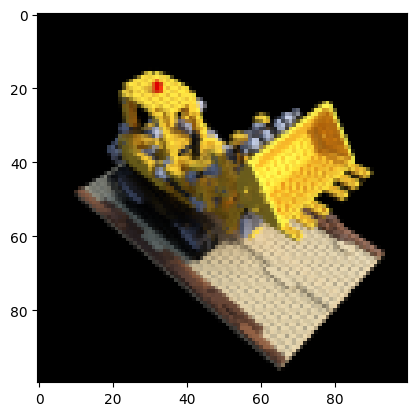

In [9]:
# Load the dataset from the NPZ file
data = np.load('tiny_nerf_data.npz')

# Extract images, poses, and focal length from the loaded data
images = data['images']  # Training images
poses = data['poses']    # Camera poses corresponding to the images
focal = data['focal']    # Focal length of the camera

# Get the height and width of the images
H, W = images.shape[1:3]  # Assuming images are in the format (num_images, H, W, channels)

# Print the shapes of the loaded data and the focal length
print(images.shape, poses.shape, focal)

# Determine the device to use for training ('cuda' if available, otherwise 'cpu')
device = "cuda" if torch.cuda.is_available() else "cpu"

# Select a test image and its corresponding pose for evaluation
testimg, testpose = images[101], poses[101]

# Use the first 100 images and poses for training
images = images[:100, ..., :3]  # Select images up to index 100 and keep only RGB channels
poses = poses[:100]            # Select poses up to index 100

# Display the test image
plt.imshow(testimg)
plt.show()

# Convert the test image and pose to PyTorch tensors and move them to the device
testimg = torch.from_numpy(testimg).float().to("cuda")  # Test image as a PyTorch tensor
testpose = torch.from_numpy(testpose).float().to("cuda")  # Test pose as a PyTorch tensor

## Train

Using device: cuda
Iteration: 0, Loss: 0.180494, Time: 0.02 secs per iter


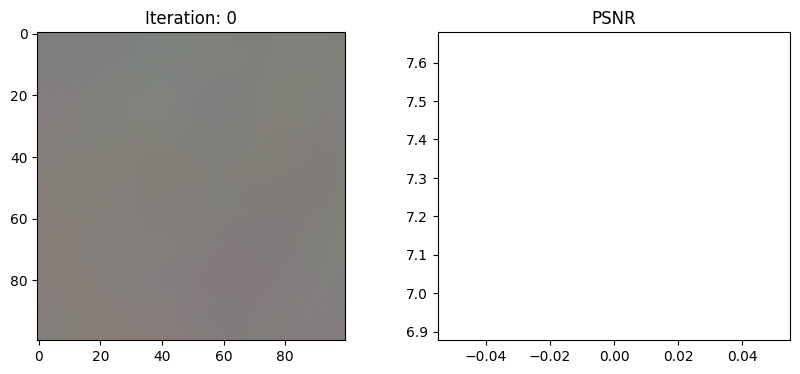

Iteration: 50, Loss: 0.025210, Time: 0.36 secs per iter


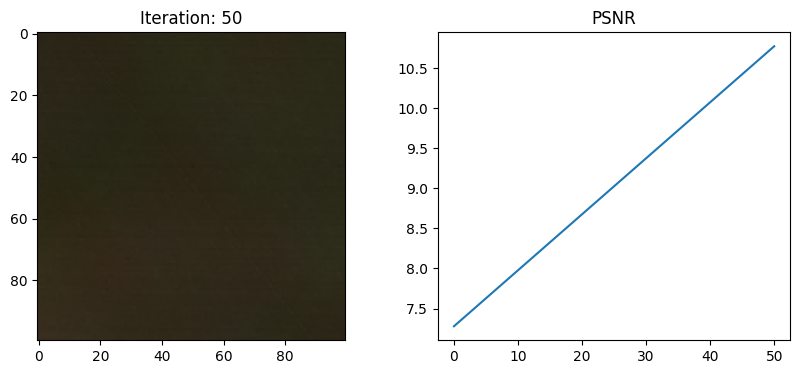

Iteration: 100, Loss: 0.086875, Time: 0.37 secs per iter


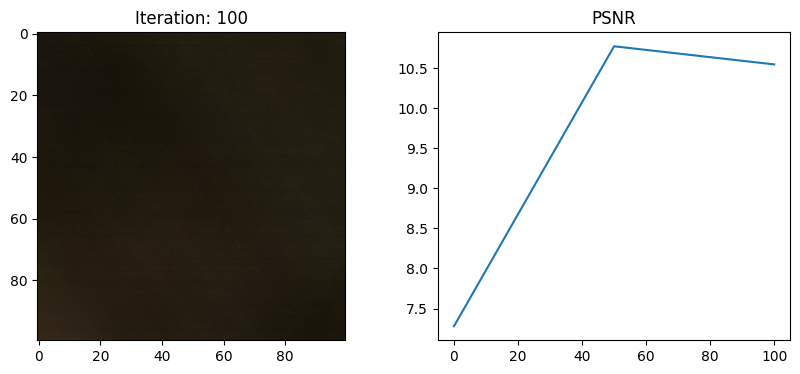

Iteration: 150, Loss: 0.037764, Time: 0.37 secs per iter


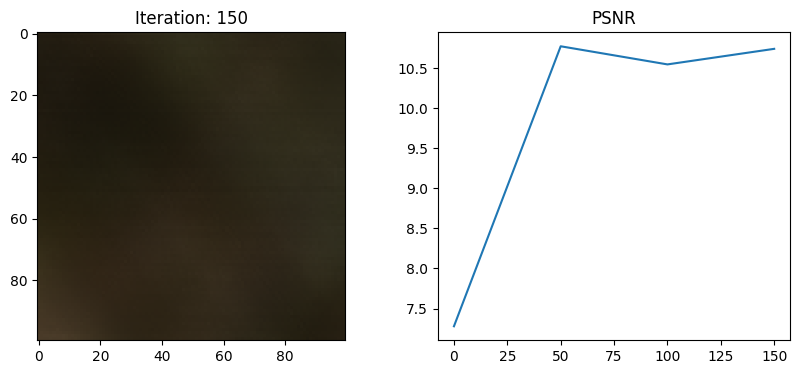

Iteration: 200, Loss: 0.054017, Time: 0.37 secs per iter


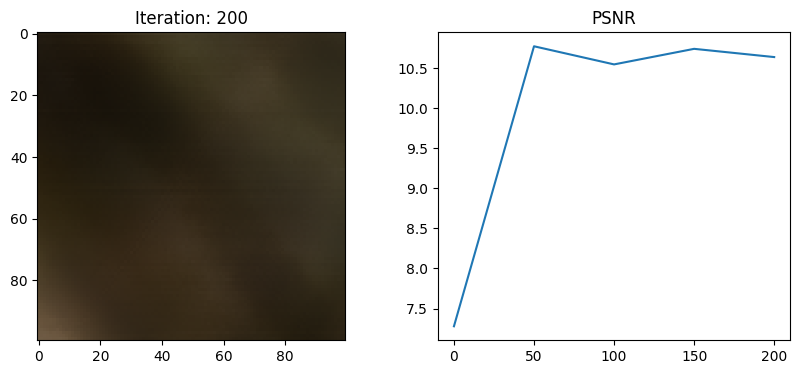

In [ ]:
model = train(images,poses,H,W,focal,testpose,testimg,device)

## Render Video

In [ ]:
# Import necessary libraries (assumed to be imported elsewhere in the notebook)
import torch
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive, widgets

# Transformation matrices in PyTorch
# These functions define basic transformation matrices for translation and rotation.

# Translation matrix along the z-axis (forward/backward)
trans_t = lambda t: torch.tensor([
    [1, 0, 0, 0],  # First row: [1, 0, 0, 0] (x-axis unchanged)
    [0, 1, 0, 0],  # Second row: [0, 1, 0, 0] (y-axis unchanged)
    [0, 0, 1, t],  # Third row: [0, 0, 1, t] (z-axis translated by 't')
    [0, 0, 0, 1]   # Fourth row: [0, 0, 0, 1] (homogeneous coordinates)
], dtype=torch.float32)  # Data type is set to float32

# Rotation matrix around the y-axis (phi) - up/down rotation
rot_phi = lambda phi: torch.tensor([
    [1, 0, 0, 0],  # First row: [1, 0, 0, 0] (x-axis unchanged)
    [0, torch.cos(phi), -torch.sin(phi), 0],  # Second row: Rotation in the y-z plane
    [0, torch.sin(phi), torch.cos(phi), 0],  # Third row: Rotation in the y-z plane
    [0, 0, 0, 1]   # Fourth row: [0, 0, 0, 1] (homogeneous coordinates)
], dtype=torch.float32)  # Data type is set to float32

# Rotation matrix around the x-axis (theta) - left/right rotation
rot_theta = lambda th: torch.tensor([
    [torch.cos(th), 0, -torch.sin(th), 0],  # First row: Rotation in the x-z plane
    [0, 1, 0, 0],  # Second row: [0, 1, 0, 0] (y-axis unchanged)
    [torch.sin(th), 0, torch.cos(th), 0],  # Third row: Rotation in the x-z plane
    [0, 0, 0, 1]   # Fourth row: [0, 0, 0, 1] (homogeneous coordinates)
], dtype=torch.float32)  # Data type is set to float32


# Pose function with spherical coordinates
# This function calculates the camera-to-world (c2w) transformation matrix
# using spherical coordinates (theta, phi, radius).
def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)  # Start with translation along the z-axis (radius)
    c2w = torch.matmul(rot_phi(torch.Tensor([phi / 180. * np.pi])), c2w)  # Rotate around y-axis (phi)
    c2w = torch.matmul(rot_theta(torch.Tensor([theta / 180. * np.pi])), c2w)  # Rotate around x-axis (theta)
    c2w = torch.tensor([[-1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]], dtype=torch.float32) @ c2w  # Adjust the coordinate system
    return c2w  # Return the final camera-to-world transformation matrix


# Function for rendering based on user input
# This function takes camera parameters as input and renders an image.
def f(**kwargs):
    c2w = pose_spherical(**kwargs)  # Calculate camera-to-world transformation
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3, :4])  # Get rays (this is a placeholder, assuming 'get_rays' is defined elsewhere)
    c2w, rays_o, rays_d = map(lambda t: t.to(device), (c2w, rays_o, rays_d))  # Move tensors to the appropriate device (e.g., GPU)
    with torch.no_grad():  # Disable gradient calculation for rendering
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=64, device=device)  # Render rays (assuming 'render_rays' and 'model' are defined elsewhere)
    rgb = rgb.reshape(H, W, 3).cpu().detach()  # Reshape, move to CPU, and detach the RGB output
    img = torch.clamp(rgb, 0, 1).numpy()  # Clamp RGB values between 0 and 1 and convert to numpy

    plt.figure(2, figsize=(20, 6))  # Create a figure for displaying the image
    plt.imshow(img)  # Display the rendered image
    plt.show()  # Show the plot


# Interactive slider setup for theta, phi, and radius
# This part sets up interactive sliders for controlling the camera parameters.

# Helper function to create a slider
sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,  # Initial value of the slider
    min=mi,  # Minimum value of the slider
    max=ma,  # Maximum value of the slider
    step=.01,  # Step size of the slider
)

# Define the parameters and their ranges
names = [
    ['theta', [100., 0., 360]],  # Theta (left/right rotation): initial value 100, range 0 to 360
    ['phi', [-30., -90, 0]],  # Phi (up/down rotation): initial value -30, range -90 to 0
    ['radius', [4., 3., 5.]],  # Radius (distance): initial value 4, range 3 to 5
]

# Create the interactive plot
interactive_plot = interactive(f, **{s[0]: sldr(*s[1]) for s in names})  # Link the sliders to the rendering function 'f'
output = interactive_plot.children[-1]  # Get the output widget
output.layout.height = '350px'  # Set the height of the output widget
interactive_plot  # Display the interactive plot

In [ ]:
# Import necessary libraries (assumed to be imported elsewhere in the notebook)
import torch
import numpy as np
import imageio
from tqdm.notebook import tqdm # For progress bar

# Initialize an empty list to store frames for the video
frames = []

# Iterate over theta (camera angle) values to create frames
for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):
    # np.linspace generates 120 evenly spaced values between 0 and 360
    # (excluding 360) for the camera angle 'th'.

    # Calculate the camera-to-world transformation matrix for the current angle
    c2w = pose_spherical(th, -30., 4.)
    # This uses the 'pose_spherical' function (defined earlier)
    # with theta='th', phi=-30, and radius=4.

    # Generate rays originating from the camera and pointing into the scene
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    # Assumes 'get_rays' function is defined elsewhere to handle ray generation.
    # H, W, and focal are likely image height, width, and focal length, respectively.

    # Move tensors to the appropriate device (e.g., GPU)
    c2w, rays_o, rays_d = map(lambda t: t.to(device), (c2w, rays_o, rays_d))
    # 'device' could be 'cuda' for GPU or 'cpu' for CPU.

    # Render the scene for the current camera pose
    with torch.no_grad():  # Disable gradient calculation for rendering
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=64, device = device)
        # 'near' and 'far' define the rendering range.
        # 'N_samples' is the number of samples along each ray.

    # Reshape the RGB output to (height, width, 3)
    rgb = rgb.reshape(H, W, 3)

    # Append the current frame to the list of frames
    frames.append((255*np.clip(rgb.cpu().detach().numpy(),0,1)).astype(np.uint8))
    # Convert the RGB tensor to a NumPy array, clip values to [0, 1],
    # scale to [0, 255], and convert to uint8 data type for image saving.

# Create the video file
import imageio # Import the imageio library for video writing
f = 'video.mp4'  # Specify the output filename
imageio.mimwrite(f, frames, fps=30, quality=7)
# Use imageio.mimwrite to create the MP4 video file.
# 'frames' is the list of frames generated earlier.
# 'fps' sets the frames per second to 30.
# 'quality' sets the video quality (7 out of 10).

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)